In [1]:
from binance.client import Client
import pandas as pd
import gym
from gym_anytrading.envs import StocksEnv, ForexEnv
from stable_baselines3 import A2C,PPO,DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import CallbackList
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env
import matplotlib.pyplot as plt
import talib
import quantstats as qs
import numpy as np
import tensorboard
import os
import torch
import pandas_ta as ta
from pon import api,secret
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_price_data_binance(ticker:str,limit:int,start_str:str, end_str:str,interval = Client.KLINE_INTERVAL_1DAY)->pd.DataFrame:
    client = Client(api, secret)
    df = pd.DataFrame(client.get_historical_klines(symbol=ticker, interval=interval,start_str=start_str, end_str=end_str))
    df.columns=['date','Open','High','Low','Close','Volume','close_time','d1','d2','d3','d4','d5']
    df = df.drop(['close_time','d1','d2','d3','d4','d5'],axis=1)
    df['date'] = pd.to_datetime(df['date']*1000000)
    df['Open'] = df['Open'].astype(float)
    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)
    df['Close'] = df['Close'].astype(float)
    df.set_index('date',inplace=True)
    df['Volume'] = df['Volume'].apply(lambda x:round(float(x),2))
    return df

def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:,['PCTOpen','PCTHigh','PCTLow','PCTVolume','RSX']].to_numpy()[start:end]
    return prices, signal_features

class MyCustomEnv(ForexEnv):
    _process_data = add_signals


In [3]:
# traindf = get_price_data_binance('BTCUSDT',1000,'29 Oct, 2019','30 Nov, 2022',interval = Client.KLINE_INTERVAL_1HOUR)
# testdf = get_price_data_binance('BTCUSDT',1000,'1 Dec, 2022','31 Dec, 2022',interval = Client.KLINE_INTERVAL_1HOUR)
traindf = pd.read_csv('traindf.csv')
testdf = pd.read_csv('testdf.csv')
traindf.set_index('Date',inplace=True)
testdf.set_index('Date',inplace=True)

In [10]:
# traindf['NOpen'] = (traindf['Open'] - traindf['Open'].mean()) / traindf['Open'].std()
# traindf['NHigh'] = (traindf['High'] - traindf['High'].mean()) / traindf['High'].std()
# traindf['NLow'] = (traindf['Low'] - traindf['Low'].mean()) / traindf['Low'].std()
# traindf['NClose'] = (traindf['Close'] - traindf['Close'].mean()) / traindf['Close'].std()
# traindf['NVolume'] = (traindf['Volume'] - traindf['Volume'].mean()) / traindf['Volume'].std()

# testdf['NOpen'] = (testdf['Open'] - testdf['Open'].mean()) / testdf['Open'].std()
# testdf['NHigh'] = (testdf['High'] - testdf['High'].mean()) / testdf['High'].std()
# testdf['NLow'] = (testdf['Low'] - testdf['Low'].mean()) / testdf['Low'].std()
# testdf['NClose'] = (testdf['Close'] - testdf['Close'].mean()) / testdf['Close'].std()
# testdf['NVolume'] = (testdf['Volume'] - testdf['Volume'].mean()) / testdf['Volume'].std()

traindf['RSX'] = ta.rsx(traindf['Close'],14)
testdf['RSX'] = ta.rsx(testdf['Close'],14)
traindf['hammer'] = ta.cdl_pattern(traindf['Open'],traindf['High'],traindf['Low'],traindf['Close'],name="hammer")
traindf['morningstar'] = ta.cdl_pattern(traindf['Open'],traindf['High'],traindf['Low'],traindf['Close'],name="morningstar")
traindf['morningdojistar'] = ta.cdl_pattern(traindf['Open'],traindf['High'],traindf['Low'],traindf['Close'],name="morningdojistar")
traindf['invertedhammer'] = ta.cdl_pattern(traindf['Open'],traindf['High'],traindf['Low'],traindf['Close'],name="invertedhammer")

traindf['PCTOpen'] = traindf['Open'].pct_change()
traindf['PCTHigh'] = traindf['High'].pct_change()
traindf['PCTLow'] = traindf['Low'].pct_change()
traindf['PCTVolume'] = traindf['Volume'].pct_change()

testdf['PCTOpen'] = testdf['Open'].pct_change()
testdf['PCTHigh'] = testdf['High'].pct_change()
testdf['PCTLow'] = testdf['Low'].pct_change()
testdf['PCTVolume'] = testdf['Volume'].pct_change()

In [11]:
traindf.loc[traindf['invertedhammer'] != 0]

,Open,High,Low,Close,Volume,RSX,hammer,PCTOpen,PCTHigh,PCTLow,PCTVolume,morningstar,morningdojistar,invertedhammer
Date,,,,,,,,,,,,,,
2019-11-05 21:00:00,9350.18,9391.25,9337.01,9340.34,834.20,55.751623,0.0,-0.004089,-0.002558,0.003872,-0.603021,0.0,0.0,100.0
2019-11-08 23:00:00,8802.17,8833.63,8768.90,8773.73,1158.28,30.105354,0.0,-0.008205,-0.005353,-0.003765,-0.150285,0.0,0.0,100.0
2019-11-13 05:00:00,8732.13,8752.44,8722.75,8725.69,610.61,56.050159,0.0,-0.003979,-0.001714,0.002385,-0.124134,0.0,0.0,100.0
2019-11-16 06:00:00,8467.60,8478.36,8461.04,8462.81,607.93,40.058907,0.0,-0.000281,0.000350,0.000853,-0.086932,0.0,0.0,100.0
2019-11-17 10:00:00,8535.88,8547.62,8520.00,8525.00,1043.23,56.031947,0.0,-0.002179,-0.005146,0.001881,-0.525856,0.0,0.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-27 03:00:00,20204.25,20249.65,20188.22,20203.18,5172.98,18.595523,0.0,-0.003636,-0.002238,0.002641,-0.291186,0.0,0.0,100.0
2022-09-20 21:00:00,18971.12,19093.45,18875.80,18875.80,7776.71,37.230202,0.0,-0.001169,0.000828,-0.003293,-0.211929,0.0,0.0,100.0
2022-10-22 09:00:00,19154.67,19174.69,19140.00,19142.66,4221.32,52.771845,0.0,-0.000465,-0.000117,-0.000602,-0.034078,0.0,0.0,100.0


In [79]:
modelname = 'PPO_PCT_CHANGE_RSX'
log_path = os.path.join('logs')
model_path = os.path.join('models',f'{modelname}')
# stats_path = os.path.join(log_path, "vec_normalize.pkl")
window_size = 50
start_index = window_size
end_index = len(traindf)
num_cpu = 1


env = MyCustomEnv(df=traindf,  frame_bound=(start_index+14,end_index), window_size=window_size)
env.trade_fee = 0

# obs = env.reset()
# action = env.action_space.sample()
# print(obs)


In [80]:
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)
TIMESTEPS = 10000
for i in range(1,100):
    model.learn(total_timesteps=TIMESTEPS,reset_num_timesteps=False,tb_log_name=modelname)
    model.save(os.path.join(f'{model_path}',f'{TIMESTEPS*i}'))

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\PPO_PCT_CHANGE_RSX_0
-----------------------------
| time/              |      |
|    fps             | 421  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 320           |
|    iterations           | 2             |
|    time_elapsed         | 12            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 1.6065314e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.693        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 3.72e+13      |
|    n_updates            | 10            

2.106979192156997


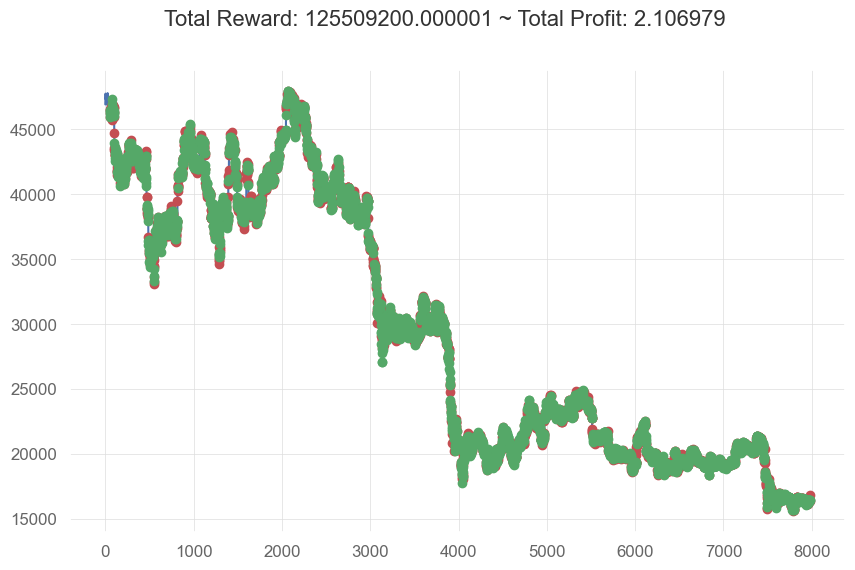

In [102]:
env = MyCustomEnv(df=traindf,  frame_bound=(start_index+14,end_index), window_size=window_size)
env.trade_fee = 0
model = PPO.load(os.path.join(f'{model_path}','990000.zip'))
obs = env.reset()
results = []
rewards = []
while True:
    action, state = model.predict(obs)
    obs, reward, done, info = env.step(action)
    rewards.append(reward)
    if done:
        break
print(info['total_profit'])
plt.cla()
env.render_all()
plt.show()
# plt.scatter(range(len(rewards)), rewards)
# plt.show()


                           Strategy
-------------------------  ----------
Start Period               2022-01-03
End Period                 2022-11-30
Risk-Free Rate             0.0%
Time in Market             1.0%

Cumulative Return          179.7%
CAGR﹪                     0.0%

Sharpe                     -
Prob. Sharpe Ratio         -
Smart Sharpe               -
Sortino                    -
Smart Sortino              -
Sortino/√2                 -
Smart Sortino/√2           -
Omega                      -

Max Drawdown               %
Longest DD Days            -
Volatility (ann.)          32.01%
Calmar                     -
Skew                       89.11
Kurtosis                   7941.0

Expected Daily %           0.01%
Expected Monthly %         9.8%
Expected Yearly %          179.7%
Kelly Criterion            -
Risk of Ruin               1.0%
Daily Value-at-Risk        -3.29%
Expected Shortfall (cVaR)  -

Max Consecutive Wins       0
Max Consecutive Losses     0
Gain/Pain Ratio

None

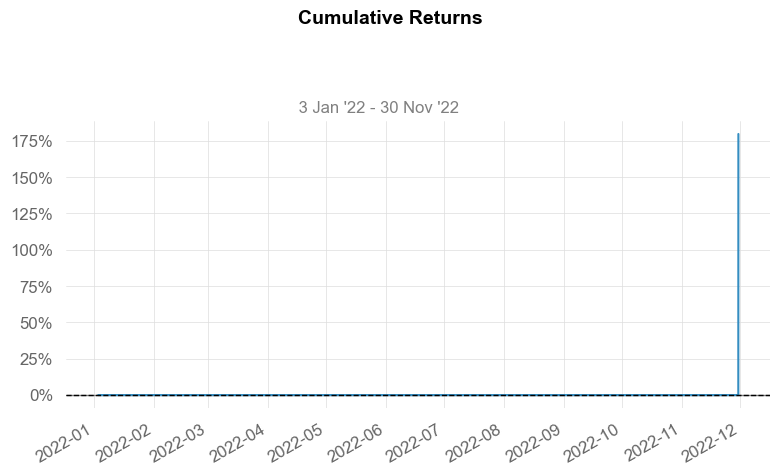

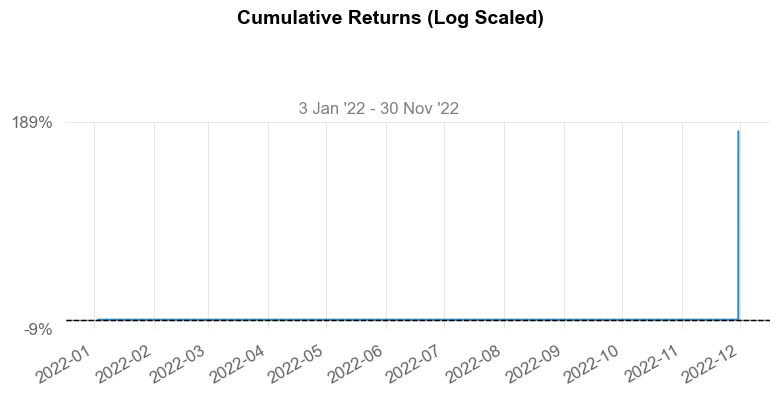

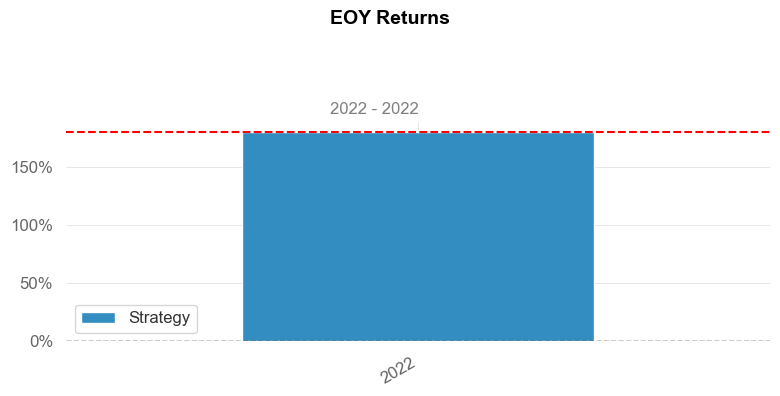

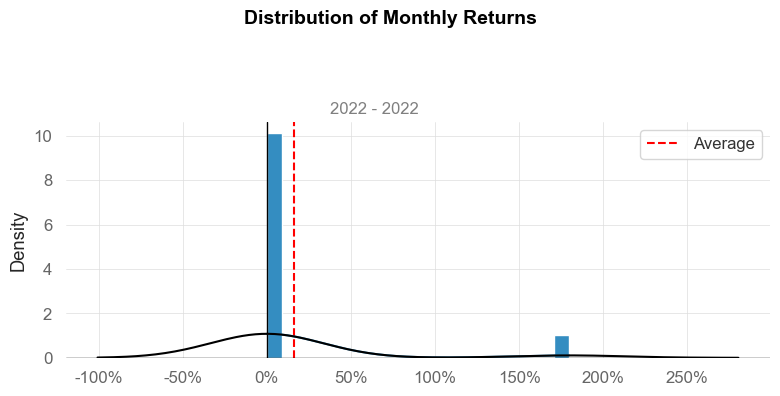

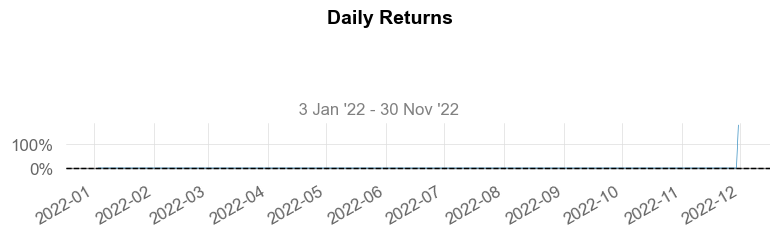

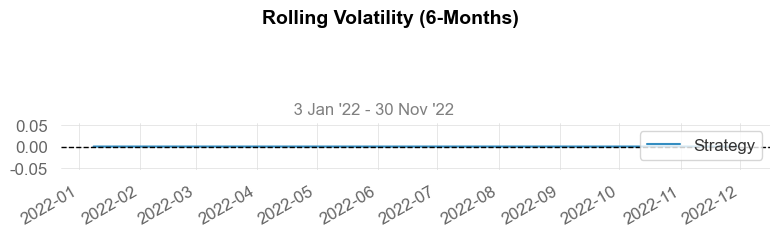

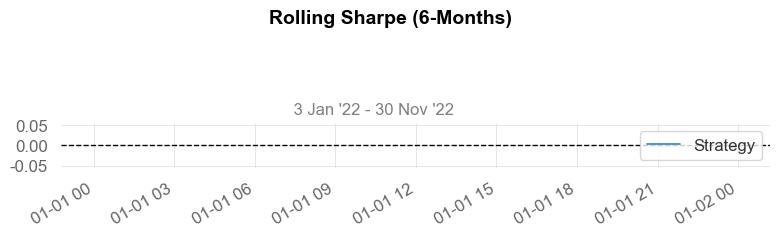

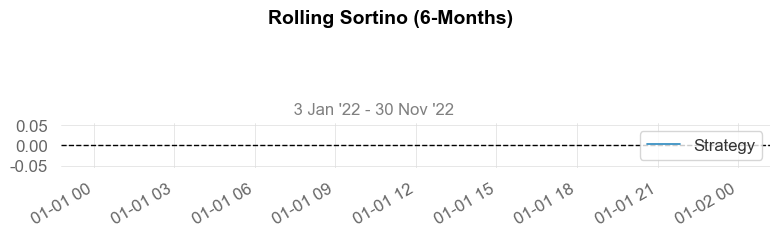

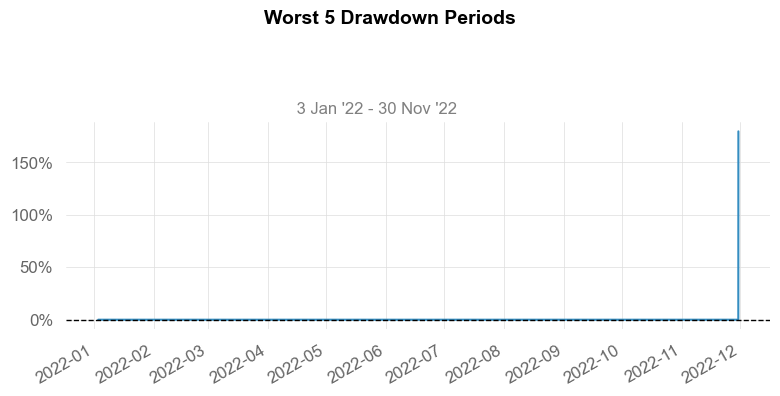

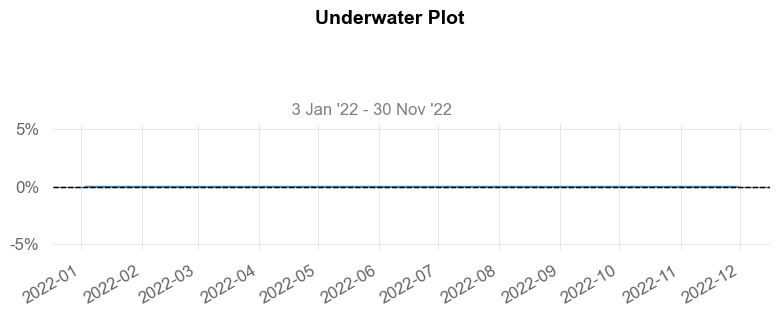

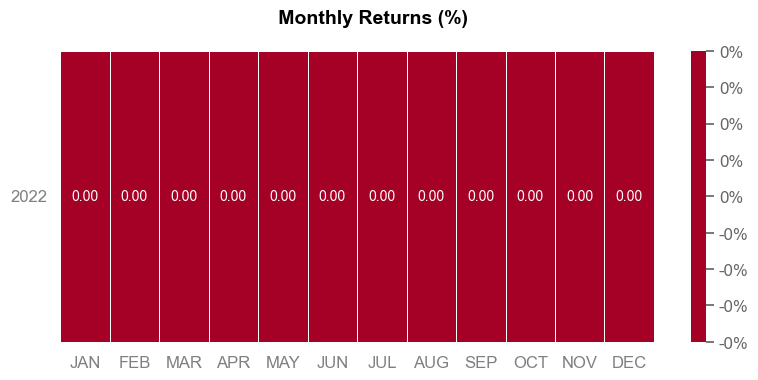

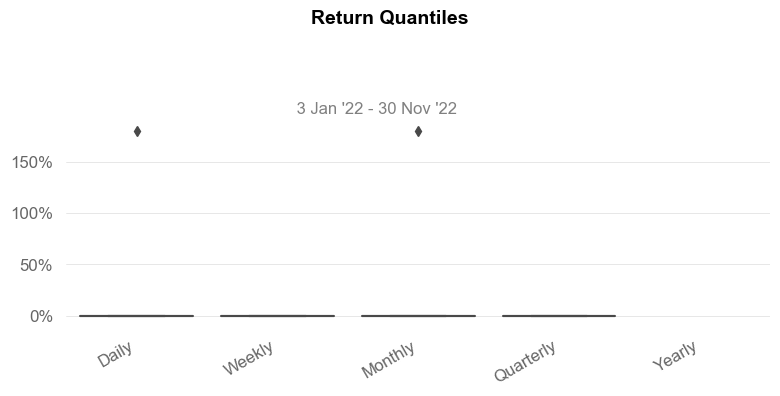

In [119]:
# qs.extend_pandas()

# net_worth = pd.Series(results['env_0'].values, index=traindf.index[start_index+1:end_index])
# returns = net_worth.iloc[1:]
# qs.reports.full(returns)